In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
import talib as ta
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')

In [4]:
def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    trades['time'] = _ensure_datetime(trades['time'])
    trades = trades.sort_values('time').reset_index(drop=True)
    df = trades.copy()
    # 处理时间列和排序
    # df['time'] = _ensure_datetime(df['time'])
    # df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['maker_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['taker_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 向量化生成 bar_id：用累计成交额除以阈值（减去微小 eps 保证等于阈值时仍归当前 bar）
    prices = df['price'].to_numpy(dtype=float)
    qtys = df['qty'].to_numpy(dtype=float)
    quotes = df['quote_qty'].to_numpy(dtype=float)
    signs = np.where(df['is_buyer_maker'].to_numpy(), -1.0, 1.0)

    cs_quote_all = np.cumsum(quotes)
    # 关键修正：使用“当前成交前”的累计额决定 bar_id，保证当前成交仍归属当前 bar
    cs_quote_prev = cs_quote_all - quotes
    bar_ids = np.floor(cs_quote_prev / float(dollar_threshold)).astype(int)
    df['bar_id'] = bar_ids

    df = df.reset_index().rename(columns={'index': 'original_index'})
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'maker_qty': 'sum',
        'taker_qty': 'sum',
        'original_index': ['first', 'last']
    }
    
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume',
        'start_trade_idx', 
        'end_trade_idx'
    ]

    # 交易笔数（每个 bar 的 size）
    g['trades'] = df.groupby('bar_id').size().values
    
    # 前缀和快照采用向量化一次性计算
    # 数量/金额/加权价
    csum_qty = np.cumsum(qtys)
    csum_signed_qty = np.cumsum(signs * qtys)
    csum_quote = cs_quote_all
    csum_signed_quote = np.cumsum(signs * quotes)
    csum_pxqty = np.cumsum(prices * qtys)
    # 波动相关：对数收益、绝对值与双乘
    logp = np.log(prices)
    r = np.diff(logp)
    ret2 = np.r_[0.0, r * r]
    abs_r = np.r_[0.0, np.abs(r)]
    bp_core = np.r_[0.0, np.r_[0.0, abs_r[1:] * abs_r[:-1]]]
    csum_ret2 = np.cumsum(ret2)
    csum_abs_r = np.cumsum(abs_r)
    csum_bpv = np.cumsum(bp_core)

    end_idx = g['end_trade_idx'].to_numpy(dtype=int)
    g['cs_qty'] = csum_qty[end_idx]
    g['cs_quote'] = csum_quote[end_idx]
    g['cs_signed_qty'] = csum_signed_qty[end_idx]
    g['cs_signed_quote'] = csum_signed_quote[end_idx]
    g['cs_pxqty'] = csum_pxqty[end_idx]
    g['cs_ret2'] = csum_ret2[end_idx]
    g['cs_abs_r'] = csum_abs_r[end_idx]
    g['cs_bpv'] = csum_bpv[end_idx]
    
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    
    return g
 

In [5]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list

raw_df = []
daily = True
start_date = '2025-06-01'
end_date = '2025-06-20'
dollar_threshold=10000*60000
dollar_threshold_str = str(dollar_threshold).replace("*", "_")
trades_zip_path = None

# 聚合成dollar bar的数据
bar_zip_path = None

if daily:
    trades_zip_path = f'/Users/aming/project/python/crypto-trade/output/trades-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    date_list = generate_date_range(start_date, end_date)
    for date in date_list:
        raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
else:
    trades_zip_path = f'/Volumes/Ext-Disk/data/futures/um/monthly/trades/ETHUSDT/ETHUSDT-trades-2025-05.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-2025-05-01-2025-06-01-{dollar_threshold_str}.zip'
    raw_df.append(pd.read_csv(trades_zip_path))

trades_df = pd.concat(raw_df, ignore_index=True)

In [6]:
if bar_zip_path is not None and os.path.exists(bar_zip_path):
    bars = pd.read_csv(bar_zip_path)
else:
    bars = build_dollar_bars(trades_df, dollar_threshold=dollar_threshold)
    os.makedirs(os.path.dirname(bar_zip_path), exist_ok=True)
    bars.to_csv(bar_zip_path, index=False,compression={'method': 'zip', 'archive_name': 'bars.csv'})

In [7]:
trades_df

,id,price,qty,quote_qty,time,is_buyer_maker
0,5751171852,2527.08,0.009,22.74372,2025-06-01 00:00:04.779,True
1,5751171853,2527.08,0.479,1210.47132,2025-06-01 00:00:04.801,True
2,5751171854,2527.08,4.460,11270.77680,2025-06-01 00:00:04.801,True
3,5751171855,2527.09,0.497,1255.96373,2025-06-01 00:00:04.802,False
4,5751171856,2527.09,0.073,184.47757,2025-06-01 00:00:04.802,False
...,...,...,...,...,...,...
98707554,5849895326,2405.43,0.116,279.02988,2025-06-20 23:59:59.106,False
98707555,5849895327,2405.43,0.275,661.49325,2025-06-20 23:59:59.106,False
98707556,5849895328,2405.42,0.025,60.13550,2025-06-20 23:59:59.288,True
98707557,5849895329,2405.43,0.249,598.95207,2025-06-20 23:59:59.375,False


<Axes: >

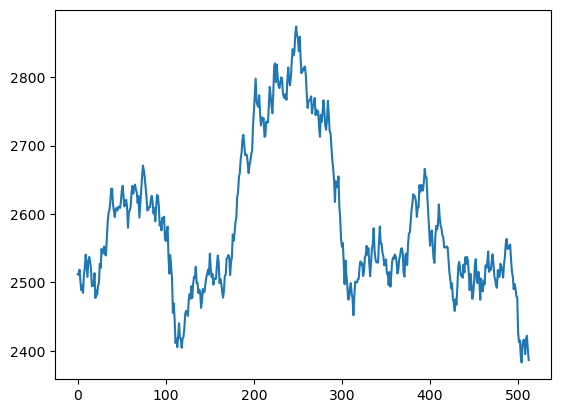

In [8]:
bars.close.plot()

<Axes: >

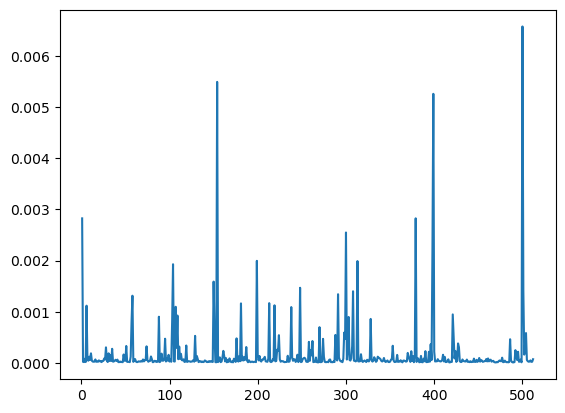

In [42]:
bars.cs_bpv.diff().plot()

In [9]:
class TradesContext:
    def __init__(self, t_ns: np.ndarray, trades: pd.DataFrame, bars_df: pd.DataFrame, price: np.ndarray, qty: np.ndarray, quote: np.ndarray, sign: np.ndarray):
        self.t_ns = t_ns  # int64 ns 时间戳（已排序）
        self.trades = trades
        self.bars_df = bars_df

        self.price = price.astype(np.float64)
        self.qty = qty.astype(np.float64)
        self.quote = quote.astype(np.float64)
        self.sign = sign.astype(np.float64)
        # self.order_type = order_type
    

        # 衍生量
        self.logp = np.log(self.price)
        self.ret = np.diff(self.logp)
        self.ret2 = np.r_[0.0, self.ret ** 2]
        # |r_t||r_{t-1}| 对齐成与 price 同长（首位补0）
        abs_r = np.abs(self.ret)
        bp_core = np.r_[0.0, np.r_[0.0, abs_r[1:] * abs_r[:-1]]]  # 与 price 对齐

        # 前缀和（与 price 同长）
        self.csum_qty = np.cumsum(self.qty)
        self.csum_quote = np.cumsum(self.quote)
        self.csum_signed_qty = np.cumsum(self.sign * self.qty)
        self.csum_signed_quote = np.cumsum(self.sign * self.quote)
        self.csum_pxqty = np.cumsum(self.price * self.qty)
        self.csum_ret2 = np.cumsum(self.ret2)
        self.csum_bpv = np.cumsum(bp_core)

    def locate(self, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Tuple[int, int]:
        s = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(start_ts, 'ns'))), side='left')
        e = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(end_ts, 'ns'))), side='left')
        return s, e
    

def _build_trades_context(trades: pd.DataFrame, bars: pd.DataFrame) -> TradesContext:
    df = trades
    bars_df = bars
    t = _ensure_datetime(df['time']).values.astype('datetime64[ns]').astype('int64')
    # t = df['time']
    order = np.argsort(t)
    t_ns = t[order]
    price = df['price'].to_numpy(dtype=float)[order]
    qty = df['qty'].to_numpy(dtype=float)[order]
    quote = (df['quote_qty'] if 'quote_qty' in df.columns else df['price'] * df['qty']).to_numpy(dtype=float)[order]
    sign = np.where(df['is_buyer_maker'].to_numpy()[order], -1.0, 1.0)
    # order_type = 
    return TradesContext(t_ns, df, bars_df, price, qty, quote, sign)

In [17]:
def _default_features_config() -> Dict[str, bool]:
    return {
        'base': False,                   # 基础汇总/VWAP/强度/买量占比
        'order_flow': True,             # GOF/签名不平衡
        'price_impact': False,           # Kyle/Amihud/Hasbrouck/半衰期/占比
        'volatility_noise': True,       # RV/BPV/Jump/微动量/均值回复/高低幅比
        'arrival_stats': False,          # 到达间隔统计
        'run_markov': False,             # run-length/Markov/翻转率
        'rolling_ofi': False,            # 滚动OFI
        'hawkes': False,                 # 聚簇（Hawkes近似）
        'path_shape': False,             # 协动相关/VWAP偏离
        'tail': False,                   # 大单尾部比例
        'tail_directional': True,       # 大单买卖方向性（分位阈值法）
    }

def _compute_interval_bar_features_fast(
    ctx: TradesContext,
    bars: pd.DataFrame,
    bar_window_start_idx: int,
    bar_window_end_idx: int,
    features_config: Optional[Dict[str, bool]] = None,
    tail_q: float = 0.9,
) -> Dict[str, float]:
    """
    使用 bar 级别的累计列（cs_*）在区间 [i0, i1) 上快速计算特征，避免逐笔切片。
    要求 bars 含有以下列：
      - start_time, end_time, open, high, low, close, volume, dollar_value, buy_volume, sell_volume
      - start_trade_idx, end_trade_idx
      - cs_qty, cs_quote, cs_signed_qty, cs_signed_quote, cs_pxqty, cs_ret2, cs_abs_r, cs_bpv
    """
    i0 = int(bar_window_start_idx)
    i1 = int(bar_window_end_idx)
    if i1 <= i0:
        return {}

    cfg = _default_features_config()
    if features_config:
        cfg.update(features_config)

    # 半开区间 [i0, i1) 的累计差分
    def _sum_cs(col: str) -> float:
        arr = bars[col].to_numpy(dtype=float)
        prev = arr[i0 - 1] if i0 > 0 else 0.0
        return float(arr[i1 - 1] - prev)

    # 基础聚合
    sum_qty = _sum_cs('cs_qty')
    sum_quote = _sum_cs('cs_quote')
    sum_signed_qty = _sum_cs('cs_signed_qty')
    sum_signed_quote = _sum_cs('cs_signed_quote')
    sum_pxqty = _sum_cs('cs_pxqty')

    # 末价/时长/强度（按 bar 数量近似强度）
    p_last = float(bars.loc[i1 - 1, 'close'])
    start_ts = bars.loc[i0, 'start_time']
    end_ts = bars.loc[i1 - 1, 'end_time']
    duration = max(1.0, (end_ts - start_ts).total_seconds())
    intensity = float((bars.loc[i0:i1 - 1, 'trades'].sum()) / duration) if 'trades' in bars.columns else float((i1 - i0) / duration)

    vwap = float(sum_pxqty / sum_qty) if sum_qty > 0 else np.nan

    # 波动性相关（用累计 ret2/bpv 的差分）
    rv = _sum_cs('cs_ret2')
    bpv = _sum_cs('cs_bpv')
    jump = max(rv - bpv, 0.0) if (np.isfinite(rv) and np.isfinite(bpv)) else np.nan

    out: Dict[str, float] = {}

    if cfg['base']:
        out.update({
            'int_trade_vwap': vwap,
            'int_trade_volume_sum': sum_qty,
            'int_trade_dollar_sum': sum_quote,
            'int_trade_signed_volume': sum_signed_qty,
            'int_trade_intensity': intensity,
            'int_trade_rv': rv,
        })

    if cfg['order_flow']:
        out.update({
            'ofi_signed_qty_sum': sum_signed_qty,
            'ofi_signed_quote_sum': sum_signed_quote,
        })

    if cfg['volatility_noise']:
        out.update({
            'rv': rv,
            'bpv': bpv,
            'jump_rv_bpv': jump,
        })

    # 仅用 bar 级累计数据难以可靠复现一些基于逐笔的高级特征（如到达间隔、滚动 OFI、路径协动等），
    # 故此函数仅返回与累计可差分的一致口径指标。

    return out


In [11]:
def make_interval_feature_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: Optional[List[int]] = [5],
    window_mode: str = 'past',  # 'past' 使用过去N个bar的[start,end)，'future' 使用未来N个bar（注意可能泄露）
    add_lags: int = 0,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
    bar_zip_path :str = None
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    标签：由 dollar bars 生成的未来 N-bar 对数收益。
    因子：对齐到对应区间 [start_time, end_time)（过去或未来N个bar）上基于逐笔成交直接计算。
    返回：X_interval, y, bars
    """

    bars = None
    if bar_zip_path is not None and os.path.exists(bar_zip_path):
        bars = pd.read_csv(bar_zip_path)
    else:
        bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
        os.makedirs(os.path.dirname(bar_zip_path), exist_ok=True)
        bars.to_csv(bar_zip_path, index=False,compression={'method': 'zip', 'archive_name': 'bars.csv'})


    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars

    bars = bars.reset_index(drop=True)
    bars['bar_id'] = bars.index
    bars['start_time'] = pd.to_datetime(bars['start_time'])
    bars['end_time'] = pd.to_datetime(bars['end_time'])
    close_s = bars.set_index('bar_id')['close']

    # 未来 N-bar 对数收益
    end_time_s = bars.set_index('bar_id')['end_time']
    y = pd.DataFrame(index=close_s.index)

    for horizon in horizon_bars: 
        y_series_log_return = np.log(close_s.shift(-horizon) / close_s)
        tH_time = end_time_s.shift(-horizon)
        y[f'log_return_{horizon}'] = y_series_log_return
        y[f't0_time_{horizon}'] = end_time_s  # 起始时间（同一时间点对不同持有期相同）
        y[f'tH_time_{horizon}'] = tH_time
        
    
    # 预构建高性能上下文（一次即可）
    ctx = _build_trades_context(trades, bars)

    # 计算每个样本的区间
    features = []
    idx = 1
    record = []
    for bar_id in close_s.index:
        if window_mode == 'past':
            bar_window_start_idx = bar_id - feature_window_bars
            if bar_window_start_idx < 0:
                features.append({'bar_id': bar_id, '_skip': True})
                continue
            bar_window_end_idx = bar_id - 1
            record.append({
                'bar_id': bar_id,
                'bar_window_start_idx': bar_window_start_idx,
                'bar_window_end_idx': bar_window_end_idx,
                'horizon_bar_idx': bar_id + horizon_bars[-1]
            })

            feature_start_ts = bars.loc[bar_window_start_idx, 'start_time']
            feature_end_ts = bars.loc[bar_window_end_idx, 'end_time']
            feat = _compute_interval_bar_features_fast(ctx=ctx, bars=bars, bar_window_start_idx=bar_window_start_idx, bar_window_end_idx=bar_window_end_idx)
            # feat = _compute_interval_bar_features_fast(ctx=ctx, start_ts=feature_start_ts, end_ts=feature_end_ts, bars=bars, bar_window_start_idx=bar_window_start_idx, bar_window_end_idx=bar_window_end_idx)
            if idx % 50 == 0:
                print(f'idx={idx}, total={len(close_s.index)}')
            idx = idx + 1
            feat['bar_id'] = bar_id
            feat['feature_start'] = feature_start_ts  # 特征计算区间的开始
            feat['feature_end'] = feature_end_ts      # 特征计算区间的结束
            feat['prediction_time'] = bars.loc[bar_id, 'end_time']  # 预测时间点
            for horizon in horizon_bars:
                if bar_id + horizon < len(bars) :
                    feat[f'settle_time_{horizon}'] = bars.loc[bar_id + horizon, 'end_time']
                else:
                    feat[f'settle_time_{horizon}'] = np.nan
            features.append(feat)

    X = pd.DataFrame(features).set_index('bar_id')
    if '_skip' in X.columns:
        keep_idx = X['_skip'] != True
        X = X.loc[keep_idx].drop(columns=['_skip'])
    
    # 对齐标签
    y = y.loc[X.index]

    # 可选：对区间因子再做滞后/滚动（通常不需要，默认不加）
    # if add_lags or rolling_windows:
    #     X = _add_bar_lags_and_rollings(
    #         X,
    #         add_lags=add_lags,
    #         rolling_windows=rolling_windows,
    #         rolling_stats=rolling_stats,
    #     ).dropna()
    #     y = y.loc[X.index]

    return X, y, bars

In [12]:
def run_bar_interval_pipeline_v2(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: Optional[List[int]] = [5],
    window_mode: str = 'past',
    n_splits: int = 5,
    embargo_bars: Optional[int] = None,
    model_type: str = 'ridge',
    random_state: int = 42,
    bar_zip_path = bar_zip_path
):
    """
    按 N 个 dollar bar 定义的时间区间计算因子，标签为未来 N-bar 对数收益；
    使用区间的真实 end_time 作为索引做 Purged K-Fold，embargo 由 bar 中位时长换算。
    """
    X, y, bars = make_interval_feature_dataset(
        trades=trades,
        dollar_threshold=dollar_threshold,
        feature_window_bars=feature_window_bars,
        horizon_bars=horizon_bars,
        window_mode=window_mode,
        bar_zip_path = bar_zip_path
    )
    
    mask = y[f'log_return_{horizon_bars[-1]}'].notna() & np.isfinite(y[f'log_return_{horizon_bars[-1]}'].values)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan)
    y = y.loc[X.index]
    # bars = bars[bars['end_time'].isin(X['feature_end'])]

    if X.empty or y.empty:
        print('数据不足或阈值设置过大，无法构造区间数据集 X {} y {} bar{}'.format(len(X), len(y), len(bars)))

    X2 = X.copy()
    y2 = y.copy()
 
    return X2, y2, bars

horizon_bars = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
X2, y2, bars = run_bar_interval_pipeline_v2(
    trades=trades_df,
    dollar_threshold=dollar_threshold,
    feature_window_bars=36,
    horizon_bars = horizon_bars,
    window_mode='past',
    n_splits=5,
    embargo_bars=None,
    model_type='ridge',
    bar_zip_path=bar_zip_path
)


idx=50, total=513
idx=100, total=513
idx=150, total=513
idx=200, total=513
idx=250, total=513
idx=300, total=513
idx=350, total=513
idx=400, total=513
idx=450, total=513


In [28]:
X2.columns

Index(['ofi_signed_qty_sum', 'ofi_signed_quote_sum', 'rv', 'bpv',
       'jump_rv_bpv', 'feature_start', 'feature_end', 'prediction_time',
       'settle_time_1', 'settle_time_2', 'settle_time_3', 'settle_time_4',
       'settle_time_5', 'settle_time_6', 'settle_time_7', 'settle_time_8',
       'settle_time_9', 'settle_time_10', 'settle_time_11', 'settle_time_12',
       'settle_time_13', 'settle_time_14', 'settle_time_15', 'settle_time_16',
       'settle_time_17', 'settle_time_18'],
      dtype='object')

In [29]:
X2_y_pd = pd.concat([X2, y2], axis=1)

def winsorize_single_factor(series, quantiles=(0.01, 0.99)):
    if len(quantiles) != 2 or quantiles[0] >= quantiles[1]:
        raise ValueError("quantiles必须是(低分位, 高分位)，且低分位 < 高分位")
    
    if quantiles[0] < 0 or quantiles[1] > 1:
        raise ValueError("分位数必须在[0, 1]范围内")
    
    # 定义单组缩尾函数
    lower = series.quantile(quantiles[0])
    upper = series.quantile(quantiles[1])
    return  series.clip(lower=lower, upper=upper)

def rolling_z_score(series, rolling_window=30):
    mean_ = ta.MA(series,rolling_window)
    std_ = ta.STDDEV(series,rolling_window)
    return (series - mean_) / std_

def _robust_zscore(series: pd.Series, rolling_window = 30) -> pd.Series:
    """基于中位数与MAD的稳健z分数（避免极端值影响）。"""
    x = pd.to_numeric(series, errors='coerce')
    eps = 1e-9

    w = int(rolling_window)
    med_roll = x.rolling(window=w).median()
    mad_roll = (x - med_roll).abs().rolling(window=w).median()
    
    factor_res = 0.6745 * (x - med_roll) / (mad_roll + eps)
    return factor_res.clip(-3, 3)

def map_to_position(factor_series: pd.Series, winsorize_ratio=0.01, rolling_window=30):
    # 1. 缩尾处理（替代clip，保留梯度）
    upper = factor_series.quantile(1 - winsorize_ratio)
    lower = factor_series.quantile(winsorize_ratio)
    factor_winsorized = factor_series.clip(lower, upper)  # 仅截断极端异常值
    
    # 2. 线性缩放到[-1,1]
    min_val = factor_winsorized.min()
    max_val = factor_winsorized.max()
    if max_val == min_val:  # 避免除以0
        return pd.Series(0, index=factor_series.index)
    position = (factor_winsorized - min_val) / (max_val - min_val) * 2 - 1
    return position

def _expanding_zscore(x, ddof=1):
    # 这是相当于expanding z-score标准化，但是这里的标准差是用的无偏估计
    x = np.array(x)
    x = np.nan_to_num(x)
    x_cumsum = np.cumsum(x)
    x_squared_cumsum = np.cumsum(x ** 2)
    count = np.arange(1, len(x) + 1)
    x_mean = x_cumsum / count
    x_std = np.sqrt(((x_squared_cumsum - 2 * x_cumsum * x_mean) / count) + x_mean ** 2) * np.sqrt(
        count / (count - ddof))
    x_value = (x - x_mean) / x_std
    # clip的值，需要测算，没有在log_return 基础上乘1000
    x_value = np.clip(x_value, -6, 6)
    x_value = np.nan_to_num(x_value)

    return x_value

def expanding_zscore(series: pd.Series, eps: float = 1e-9) -> pd.Series:
    """
    计算序列的累积z-score标准化（expanding z-score）
    
    公式：z = (x - 累积均值) / 累积标准差
    其中，累积均值和累积标准差是从序列起始到当前位置的所有数据计算得到
    
    参数:
        series: 输入的pandas序列
        eps: 防止除以零的极小值，默认1e-9
        
    返回:
        pd.Series: 标准化后的序列，索引与输入一致
    """
    # 将序列转换为数值型，无法转换的值设为NaN
    x = pd.to_numeric(series, errors='coerce')
    
    # 计算累积均值（从第一个元素到当前元素的均值）
    expanding_mean = x.expanding().mean()
    
    # 计算累积标准差（使用N-1的无偏估计）
    expanding_std = x.expanding().std(ddof=1)  # ddof=1表示除以N-1
    
    # 计算z-score，加入eps避免除以零
    z_score = (x - expanding_mean) / (expanding_std + eps)
    
    return z_score


X2_y_pd


,ofi_signed_qty_sum,ofi_signed_quote_sum,rv,bpv,jump_rv_bpv,feature_start,feature_end,prediction_time,settle_time_1,settle_time_2,...,tH_time_15,log_return_16,t0_time_16,tH_time_16,log_return_17,t0_time_17,tH_time_17,log_return_18,t0_time_18,tH_time_18
bar_id,,,,,,,,,,,,,,,,,,,,,
36,-68092.957000,-1.628920e+08,0.013099,0.005949,0.007150,2025-06-01 00:00:04.779,2025-06-02 23:29:00.780,2025-06-03 00:08:52.184,2025-06-03 00:47:15.550,2025-06-03 01:42:11.955,...,2025-06-03 15:08:26.468,0.007299,2025-06-03 00:08:52.184,2025-06-03 15:47:10.662,0.001978,2025-06-03 00:08:52.184,2025-06-03 16:46:22.342,0.004109,2025-06-03 00:08:52.184,2025-06-03 17:43:20.027
37,-57346.284000,-1.359764e+08,0.013590,0.006179,0.007410,2025-06-01 01:53:21.812,2025-06-03 00:08:52.184,2025-06-03 00:47:15.550,2025-06-03 01:42:11.955,2025-06-03 02:13:53.637,...,2025-06-03 15:47:10.662,-0.003105,2025-06-03 00:47:15.550,2025-06-03 16:46:22.342,-0.000974,2025-06-03 00:47:15.550,2025-06-03 17:43:20.027,0.000580,2025-06-03 00:47:15.550,2025-06-03 19:45:22.763
38,-19163.548000,-7.601227e+07,0.007626,0.003376,0.004250,2025-06-01 02:53:57.138,2025-06-03 00:47:15.550,2025-06-03 01:42:11.955,2025-06-03 02:13:53.637,2025-06-03 02:53:36.189,...,2025-06-03 16:46:22.342,-0.007736,2025-06-03 01:42:11.955,2025-06-03 17:43:20.027,-0.006181,2025-06-03 01:42:11.955,2025-06-03 19:45:22.763,-0.010296,2025-06-03 01:42:11.955,2025-06-03 20:38:11.420
39,-7275.491000,-4.423332e+07,0.007642,0.003384,0.004258,2025-06-01 05:27:06.053,2025-06-03 01:42:11.955,2025-06-03 02:13:53.637,2025-06-03 02:53:36.189,2025-06-03 03:17:59.637,...,2025-06-03 17:43:20.027,-0.006212,2025-06-03 02:13:53.637,2025-06-03 19:45:22.763,-0.010326,2025-06-03 02:13:53.637,2025-06-03 20:38:11.420,-0.021914,2025-06-03 02:13:53.637,2025-06-03 21:56:14.402
40,18699.258000,2.246077e+07,0.007706,0.003412,0.004293,2025-06-01 08:56:46.411,2025-06-03 02:13:53.637,2025-06-03 02:53:36.189,2025-06-03 03:17:59.637,2025-06-03 04:17:44.215,...,2025-06-03 19:45:22.763,-0.001535,2025-06-03 02:53:36.189,2025-06-03 20:38:11.420,-0.013123,2025-06-03 02:53:36.189,2025-06-03 21:56:14.402,-0.004125,2025-06-03 02:53:36.189,2025-06-03 23:12:16.793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,61269.541000,1.574260e+08,0.003795,0.001557,0.002238,2025-06-18 14:51:19.758,2025-06-20 10:24:30.125,2025-06-20 12:02:20.200,2025-06-20 13:40:23.944,2025-06-20 14:01:44.390,...,2025-06-20 17:47:41.891,-0.053970,2025-06-20 12:02:20.200,2025-06-20 18:02:38.537,-0.053796,2025-06-20 12:02:20.200,2025-06-20 18:28:15.810,-0.062600,2025-06-20 12:02:20.200,2025-06-20 19:14:45.470
491,44093.241001,1.136994e+08,0.003706,0.001521,0.002184,2025-06-18 15:13:52.603,2025-06-20 12:02:20.200,2025-06-20 13:40:23.944,2025-06-20 14:01:44.390,2025-06-20 14:25:49.991,...,2025-06-20 18:02:38.537,-0.055966,2025-06-20 13:40:23.944,2025-06-20 18:28:15.810,-0.064771,2025-06-20 13:40:23.944,2025-06-20 19:14:45.470,-0.055300,2025-06-20 13:40:23.944,2025-06-20 19:59:15.761
492,18756.732001,4.958987e+07,0.003680,0.001511,0.002168,2025-06-18 15:52:01.990,2025-06-20 13:40:23.944,2025-06-20 14:01:44.390,2025-06-20 14:25:49.991,2025-06-20 14:47:05.867,...,2025-06-20 18:28:15.810,-0.055934,2025-06-20 14:01:44.390,2025-06-20 19:14:45.470,-0.046464,2025-06-20 14:01:44.390,2025-06-20 19:59:15.761,-0.044716,2025-06-20 14:01:44.390,2025-06-20 21:01:49.271


[0.0633964945252141, 0.08496610306123027, 0.08259959508335044, 0.06956213630766452, 0.06987167216689458, 0.06218658597805778, 0.05246573410340244, 0.03944399479541245, 0.032037630809216754, 0.028194668604467434, 0.024628503567025395, 0.023738126969741823, 0.01826864429657776, 0.015494359581126084, 0.010670966783121806, 0.010861994872485126, 0.014695992159353022, 0.018787970728138502]


<Axes: >

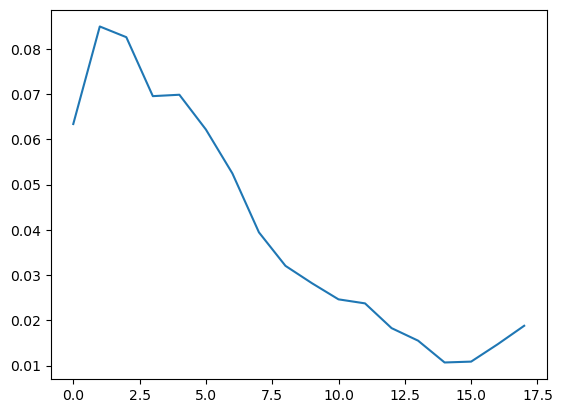

In [32]:
factor_name = 'ofi_signed_quote_sum'


def build_factor_corr(factor_name):
    factor_series = X2_y_pd[f'{factor_name}']
    winsorize_value = _robust_zscore(factor_series)
    # factor_series = winsorize_value
    # factor_robust_zscore = _expanding_zscore(winsorize_value, rolling_window=30)
    factor_robust_zscore = winsorize_single_factor(winsorize_value)

    corr_list = []
    for horizon in horizon_bars:
        corr_list.append(factor_robust_zscore.corr(X2_y_pd[f'log_return_{horizon}']))
    return factor_robust_zscore, corr_list

factor_robust_zscore, corr_list = build_factor_corr(factor_name)

# # print(factor_robust_zscore[factor_robust_zscore > 1])
print(corr_list)
pd.Series(corr_list).plot()
# factor_robust_zscore.hist(bins=100)